In [1]:
import numpy 
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Lambda
from keras.optimizers import Adam
import theano
import theano.tensor as T


numpy.random.seed(0)

mu = 4
sigma = 2

# use GAN to generate gaussian distribution from uniform distribution
batch_size = 128
data_dim = 1
mid_dim = 6
sample_dim = 20

Using Theano backend.


In [2]:
# plot states
def plot_states(D, G):
    f,ax=plt.subplots(1)
    n = 50
    # p_data
    n_dist = numpy.random.normal(mu, sigma, 1000).astype('float32')
    u_dist = numpy.random.uniform(-sigma, sigma, (1000, sample_dim)).astype('float32')
    gn_dist = G(u_dist)[:,0]
    ax.hist(n_dist, n, label='p_data', normed=True)
    ax.hist(gn_dist, n, label='p_g', normed=True)
        
    dx = []
    xx = []
    for i in numpy.arange(mu-sigma*4, mu+sigma*4, 0.5):
        # Predict of real data
        tmp_n = n_dist[numpy.where((n_dist <= i+1) & (n_dist > i))]
        if len(tmp_n) != 0:
            tmp_d = D.predict(tmp_n)[:,0].sum() 
            tmp_m = tmp_n.shape[0]
        else:
            tmp_d = 0
            tmp_m = 0
                 
        # Predict of fake data
        tmp_n = gn_dist[numpy.where((gn_dist <= i+1) & (gn_dist > i))]
        if len(tmp_n) != 0:
            tmp_d += D.predict(tmp_n)[:,0].sum() 
            tmp_m += tmp_n.shape[0]
        if tmp_m > 0:
            dx.append(tmp_d / tmp_m)
            xx.append(i)
    ax.plot(xx, dx, label='d', marker='*')
    plt.legend()
    


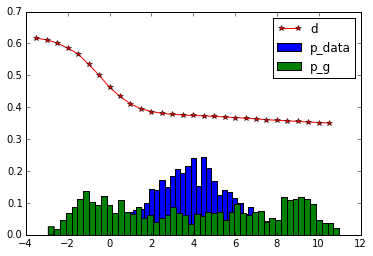

In [3]:
# simple mlp discriminator
discriminator = Sequential()
discriminator.add(Dense(mid_dim, input_dim=data_dim, activation='tanh'))
discriminator.add(Dense(mid_dim, activation='tanh'))
discriminator.add(Dense(1, activation='sigmoid'))

# simple mlp generator
generator = Sequential()
generator.add(Dense(mid_dim, input_dim=sample_dim, activation='tanh'))
generator.add(Dense(mid_dim, activation='tanh'))
generator.add(Dense(data_dim, activation='tanh'))
generator.add(Lambda(lambda x: x * 4 * sigma + mu)) # scale
sample_fake = theano.function(generator.inputs, generator.output)


discriminator.trainable = False
generator.add(discriminator)

# training setting
opt_g = Adam(lr=.0001) 
generator.compile(loss='binary_crossentropy', optimizer=opt_g)
opt_d = Adam(lr=.0002)
discriminator.trainable = True
discriminator.compile(loss='binary_crossentropy', optimizer=opt_d)

# plot initial state
# it's important to understand Figure 1 in 
# Goodfellow, Ian, et al. "Generative adversarial nets." Advances in Neural Information Processing Systems. 2014.
plot_states(discriminator, sample_fake) 

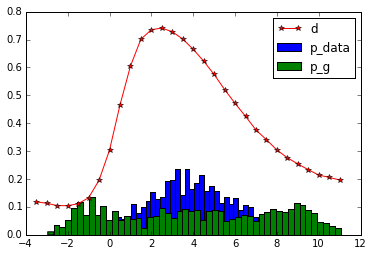

In [4]:
# pre-train the discriminator, not necessary in this simple example
n_dist = numpy.random.normal(mu, sigma, batch_size * 100).astype('float32')
u_dist = numpy.random.uniform(-sigma, sigma, (batch_size * 100, sample_dim)).astype('float32')
gn_dist = sample_fake(u_dist)[:,0]
true_n_fake = numpy.hstack([n_dist, gn_dist])

y_batch = numpy.hstack([numpy.ones((batch_size * 100, )),
                             numpy.zeros((batch_size * 100, ))])
discriminator.fit(true_n_fake, y_batch, batch_size=batch_size, nb_epoch=20, verbose=0)

# after pre-training, the discriminator should converge to D*
# as described in the paper
plot_states(discriminator, sample_fake) 


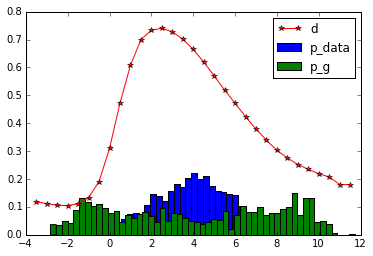

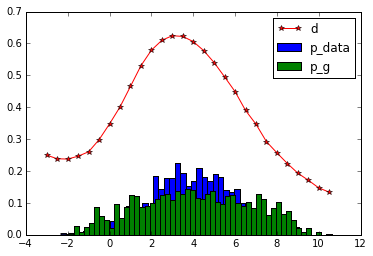

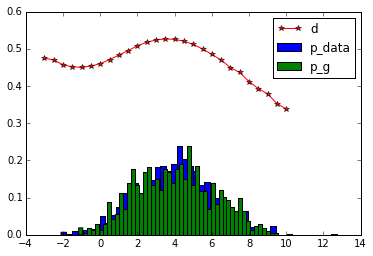

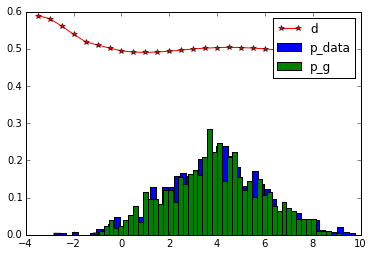

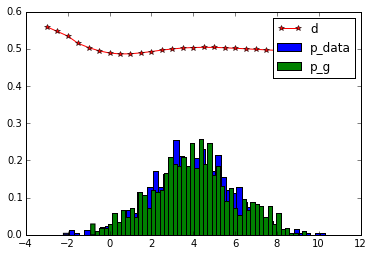

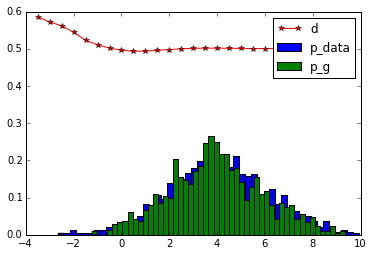

In [5]:
for i in range(2000):
    if i % 400 == 0:
        plot_states(discriminator, sample_fake) 
    for k in range(10):
        n_dist = numpy.random.normal(mu, sigma, batch_size).astype('float32')
        u_dist = numpy.random.uniform(-sigma, sigma, (batch_size, sample_dim)).astype('float32')
        gn_dist = sample_fake(u_dist)[:,0]
        true_n_fake = numpy.hstack([n_dist, gn_dist])
        y_batch = numpy.hstack([numpy.ones((batch_size, )),
                             numpy.zeros((batch_size, ))])        
        discriminator.train_on_batch(true_n_fake, y_batch)
                          
        
    all_fake = numpy.ones((batch_size, )).astype('float32')
    u_dist = numpy.random.uniform(-sigma, sigma, (batch_size, sample_dim)).astype('float32')
    generator.train_on_batch(u_dist, all_fake)
    
    
# after training, the discriminator should not be able to distinguish two distributions
# as described in the paper
plot_states(discriminator, sample_fake) 



In [ ]:
# Thanks to
# 1. https://github.com/ericjang/genadv_tutorial/blob/master/genadv1.ipynb
# 2. https://github.com/EderSantana/seya/blob/master/examples/wip-GAN.ipynb